# IEEE-CIS Fraud Detection
## Can you detect fraud from customer transactions?
*Visit [kaggle](https://www.kaggle.com/c/ieee-fraud-detection) for competition details*

**Authored by Soyoung Kang**

## Columns
- 'TransactionID'
- 'isFraud'
- 'TransactionDT'
- 'TransactionAmt'
- 'card1'
- 'TransactionAmt_residue'
- 'repeated'
- 'ProductCD_C'
- 'ProductCD_H'
- 'ProductCD_R'
- 'ProductCD_S'
- 'ProductCD_W'
- 'card2_na'
- 'card3_ran'
- 'card3_count'
- 'card4_ran'
- 'card5_ran'
- 'card5_count'
- 'card6_count'
- 'addr1_na'
- 'addr2_ran'
- 'addr2_count'
- 'dist1_na'
- 'dist2_na'
- 'C_pca1'
- 'C_pca2'


- 'TransactionID',
- 'isFraud',
-  'TransactionDT',
-  'hour', 
- 'c_fraud',
-  'card1',
- 'TransactionAmt_log',
- 'TransactionAmt_residue',
- 'repeated',
- 'ProductCD_C',
- 'ProductCD_H',
- 'ProductCD_R',
 'ProductCD_S',
 'ProductCD_W',
 'card4_ran_american express',
 'card4_ran_discover',
 'card4_ran_mastercard',
 'card4_ran_visa',
 'card2_na',
 'card3_count',
 # 'card3_fraud_ratio',
 'card5_count',
 # 'card5_fraud_ratio',
 'card6_count',
 # 'card6_fraud_ratio',
 'addr1_na',
 'addr2_count',
#  'addr2_fraud_ratio',
 'dist1_na',
 'dist2_na',
 'email_merged_ran_aim.com',
 'email_merged_ran_anonymous.com',
 'email_merged_ran_aol.com',
 'email_merged_ran_att.net',
 'email_merged_ran_bellsouth.net',
 'email_merged_ran_cableone.net',
 'email_merged_ran_centurylink.net',
 'email_merged_ran_cfl.rr.com',
 'email_merged_ran_charter.net',
 'email_merged_ran_comcast.net',
 'email_merged_ran_cox.net',
 'email_merged_ran_earthlink.net',
 'email_merged_ran_embarqmail.com',
 'email_merged_ran_frontier.com',
 'email_merged_ran_frontiernet.net',
 'email_merged_ran_gmail',
 'email_merged_ran_gmail.com',
 'email_merged_ran_gmx.de',
 'email_merged_ran_hotmail.co.uk',
 'email_merged_ran_hotmail.com',
 'email_merged_ran_hotmail.de',
 'email_merged_ran_hotmail.es',
 'email_merged_ran_hotmail.fr',
 'email_merged_ran_icloud.com',
 'email_merged_ran_juno.com',
 'email_merged_ran_live.com',
 'email_merged_ran_live.com.mx',
 'email_merged_ran_live.fr',
 'email_merged_ran_mac.com',
 'email_merged_ran_mail.com',
 'email_merged_ran_me.com',
 'email_merged_ran_msn.com',
 'email_merged_ran_netzero.com',
 'email_merged_ran_netzero.net',
 'email_merged_ran_optonline.net',
 'email_merged_ran_outlook.com',
 'email_merged_ran_outlook.es',
 'email_merged_ran_prodigy.net.mx',
 'email_merged_ran_protonmail.com',
 'email_merged_ran_ptd.net',
 'email_merged_ran_q.com',
 'email_merged_ran_roadrunner.com',
 'email_merged_ran_rocketmail.com',
 'email_merged_ran_sbcglobal.net',
 'email_merged_ran_sc.rr.com',
 'email_merged_ran_scranton.edu',
 'email_merged_ran_servicios-ta.com',
 'email_merged_ran_suddenlink.net',
 'email_merged_ran_twc.com',
 'email_merged_ran_verizon.net',
 'email_merged_ran_web.de',
 'email_merged_ran_windstream.net',
 'email_merged_ran_yahoo.co.jp',
 'email_merged_ran_yahoo.co.uk',
 'email_merged_ran_yahoo.com',
 'email_merged_ran_yahoo.com.mx',
 'email_merged_ran_yahoo.de',
 'email_merged_ran_yahoo.es',
 'email_merged_ran_yahoo.fr',
 'email_merged_ran_ymail.com',
# fraud_ratio_C







### Newly added columns
- 'TransactionAmt_residue'
- 'repeated'
- Dummy columns for ProductCD (dropped 'ProductCD')
- 'card2_na' (dropped 'card2')
- 'card3_ran' (dropped 'card3')
- 'card3_count'
- 'card4_ran' (dropped 'card4')
- 'card5_ran' (dropped 'card5')
- 'card5_count'
- 'card6_count' (based on random sampling-imputed 'card6', dropped 'card6' and 'card6_ran')
- 'addr1_na' (dropped 'addr1')
- 'addr2_ran' (dropped 'addr2')
- 'addr2_count'
- 'dist1_na' (dropped 'dist1')
- 'dist2_na' (dropped 'dist2')
- 'C_pca1', 'C_pca2'

### Dropped columns
- Dropped P_emaildomain, R_emaildomain

In [193]:
import pandas as pd
import pandas_profiling as pp
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings("ignore")

In [194]:
trns_train = pd.read_csv('../ieee-fraud-detection/train_transaction.csv', engine = 'python')

In [195]:
test = pd.read_csv('../ieee-fraud-detection/test_transaction.csv', engine = 'python')

In [196]:
col = ['TransactionID',
 'TransactionDT',
 'TransactionAmt',
 'ProductCD',
 'card1',
 'card2',
 'card3',
 'card4',
 'card5',
 'card6',
 'addr1',
 'addr2',
 'dist1',
 'dist2',
 'P_emaildomain',
 'R_emaildomain',
 'C1',
 'C2',
 'C3',
 'C4',
 'C5',
 'C6',
 'C7',
 'C8',
 'C9',
 'C10',
 'C11',
 'C12',
 'C13',
 'C14']

trns_test = test[col]

# 0. Hour, 국가별

In [201]:
temp_train = trns_train.copy()
temp_train["TransactionDT"] = temp_train["TransactionDT"]/24/3600
# temp2["day"] = temp2["TransactionDT"]//1
temp_train["hour"] = temp_train["TransactionDT"]%1*24//1
# temp2["min"] = temp2["hour"]%1*60//1
# temp2["day2"]=temp2["day"]%7
temp_train.rename(columns={"card3_ran" : "card3"}, inplace=True)

In [202]:
temp_test = trns_test.copy()
temp_test["TransactionDT"] = temp_test["TransactionDT"]/24/3600
# temp2["day"] = temp2["TransactionDT"]//1
temp_test["hour"] = temp_test["TransactionDT"]%1*24//1
# temp2["min"] = temp2["hour"]%1*60//1
# temp2["day2"]=temp2["day"]%7
temp_test.rename(columns={"card3_ran" : "card3"}, inplace=True)

trns_test = temp_test

In [203]:
CH = temp_train[["TransactionID", "isFraud", "card3", "hour"]].copy()
CH_group = CH.groupby(["card3", "hour", "isFraud"]).size() #card3의 시간별 사기거래를 묶음
CHF_dict = dict(CH_group) #딕셔너리화 하기
CHF_dict

card3_list = list(temp_train["card3"].unique()) #card3의 유니크한 값들을 list화 함
c_fraud = []
for c in card3_list: #c는 card3(국가)
  for i in range(24): #i는 시간
    if((c, i, 0) in CHF_dict): #(국가, 시간, 사기거래 아닌것) 존재하는 지 검사
      if((c, i, 1) in CHF_dict): #(국가, 시간, 사기거래) 존재하는 지 검사, 있으면 그 국가의 그 시간대별로 사기비율을 구하고 없으면 0으로 한다
        non_fraud = int(CHF_dict[(c, i, 0)]) #사기거래 아닌 양
        fraud = int(CHF_dict[(c, i, 1)]) #사기거래인 양
        fraud_percent = 100*fraud/(non_fraud + fraud) #사기 비율 구하기
        c_fraud.append((c,i, fraud_percent, non_fraud + fraud)) #빈 리스트에 추가하기
      else:
        non_fraud = int(CHF_dict[(c, i, 0)]) #사기거래 아닌 양
        c_fraud.append((c,i, 0, non_fraud))
    else:
      pass
hour_a = pd.DataFrame(c_fraud, columns=["card3", "hour", "c_fraud", "amount_per_hour"])
country_hour = pd.merge(CH, hour_a,  how='left', on=["card3", "hour"])
#country_hour.to_csv("hour_2.csv", mode='w')

In [204]:
country_hour.drop(columns = ['card3', 'isFraud', 'amount_per_hour'], inplace = True)

In [205]:
country_hour.columns

Index(['TransactionID', 'hour', 'c_fraud'], dtype='object')

In [206]:
df = trns_train.merge(country_hour, on = ['TransactionID'] )

In [207]:
df.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V332,V333,V334,V335,V336,V337,V338,V339,hour,c_fraud
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,2.088482
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,2.088482
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,2.088482
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,2.088482
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.088482


In [208]:
list(df.columns)

['TransactionID',
 'isFraud',
 'TransactionDT',
 'TransactionAmt',
 'ProductCD',
 'card1',
 'card2',
 'card3',
 'card4',
 'card5',
 'card6',
 'addr1',
 'addr2',
 'dist1',
 'dist2',
 'P_emaildomain',
 'R_emaildomain',
 'C1',
 'C2',
 'C3',
 'C4',
 'C5',
 'C6',
 'C7',
 'C8',
 'C9',
 'C10',
 'C11',
 'C12',
 'C13',
 'C14',
 'D1',
 'D2',
 'D3',
 'D4',
 'D5',
 'D6',
 'D7',
 'D8',
 'D9',
 'D10',
 'D11',
 'D12',
 'D13',
 'D14',
 'D15',
 'M1',
 'M2',
 'M3',
 'M4',
 'M5',
 'M6',
 'M7',
 'M8',
 'M9',
 'V1',
 'V2',
 'V3',
 'V4',
 'V5',
 'V6',
 'V7',
 'V8',
 'V9',
 'V10',
 'V11',
 'V12',
 'V13',
 'V14',
 'V15',
 'V16',
 'V17',
 'V18',
 'V19',
 'V20',
 'V21',
 'V22',
 'V23',
 'V24',
 'V25',
 'V26',
 'V27',
 'V28',
 'V29',
 'V30',
 'V31',
 'V32',
 'V33',
 'V34',
 'V35',
 'V36',
 'V37',
 'V38',
 'V39',
 'V40',
 'V41',
 'V42',
 'V43',
 'V44',
 'V45',
 'V46',
 'V47',
 'V48',
 'V49',
 'V50',
 'V51',
 'V52',
 'V53',
 'V54',
 'V55',
 'V56',
 'V57',
 'V58',
 'V59',
 'V60',
 'V61',
 'V62',
 'V63',
 'V64',
 'V

In [209]:
col = ['TransactionID',
 'isFraud',
 'TransactionDT','hour',
 'c_fraud', 
 'TransactionAmt',
 'ProductCD',
 'card1',
 'card2',
 'card3',
 'card4',
 'card5',
 'card6',
 'addr1',
 'addr2',
 'dist1',
 'dist2',
 'P_emaildomain',
 'R_emaildomain','C1',
 'C2',
 'C3',
 'C4',
 'C5',
 'C6',
 'C7',
 'C8',
 'C9',
 'C10',
 'C11',
 'C12',
 'C13',
 'C14']

trns_train = df[col]

# 1. TransactionAmt
- log scale
- 소숫점 이하 자릿수 15자리 이상 여부에 대한 boolean 컬럼 생성.
- 반복 거래(card1~6정보와 TransactionAmt, ProductCD가 일치하는 거래)에 대해 'repeated' 컬럼 생성.
    * value: 해당 카드의 전체 거래건수 대비 반복 거래 비율

## Log scale

In [210]:
trns_train['TransactionAmt_log'] = np.log(trns_train['TransactionAmt'])

In [211]:
trns_test['TransactionAmt_log'] = np.log(trns_train['TransactionAmt'])

## 소숫점 이하 자릿수 15자리 이상 여부에 대한 boolean 컬럼 생성.
***Add a boolean column 'TransactionAmt_residue' indicating whether TransactionAmt value exceeds 15 digits after decimal point.***

In [212]:
def num_after_point(x):
    s = str(x)
    if not '.' in s:
        return 0
    return len(s) - s.index('.') - 1 

trns_train['TransactionAmt_residue'] = ''

for index, row in trns_train.iterrows():
    r = num_after_point(row['TransactionAmt'])
    if r >= 15:
        trns_train.at[index, 'TransactionAmt_residue'] = 1
    else:
        trns_train.at[index, 'TransactionAmt_residue'] = 0

In [213]:
trns_test['TransactionAmt_residue'] = ''

for index, row in trns_test.iterrows():
    r = num_after_point(row['TransactionAmt'])
    if r >= 15:
        trns_test.at[index, 'TransactionAmt_residue'] = 1
    else:
        trns_test.at[index, 'TransactionAmt_residue'] = 0

## 반복 거래(card1~6정보와 TransactionAmt, ProductCD가 일치하는 거래)에 대해 'repeated' 컬럼 생성.
***Add a column called 'repeated' storing ratios of repeated transactions to the total transactions per each card.***
- value: 해당 카드의 전체 거래건수 대비 반복 거래 비율

In [214]:
trns_train['card_merged'] = trns_train[['card1', 'card2', 'card3', 'card4', 'card5', 'card6']].astype(str).apply(lambda x : ' '.join(x), axis = 1)

In [215]:
trns_train['transaction_temp'] = trns_train[['TransactionAmt', 'ProductCD', 'card_merged']].astype(str).apply(lambda x : ' '.join(x), axis = 1)

In [216]:
# {repeated_transaction : repeated times}
d = trns_train.groupby(['transaction_temp'])['TransactionID'].count().to_dict()
#d

In [217]:
trns_train['repeated'] = trns_train['transaction_temp'].map(d)

In [218]:
trns_train[['transaction_temp', 'repeated']]

,transaction_temp,repeated
0,68.5 W 13926 nan 150.0 discover 142.0 credit,1
1,29.0 W 2755 404.0 150.0 mastercard 102.0 credit,8
2,59.0 W 4663 490.0 150.0 visa 166.0 debit,87
3,50.0 W 18132 567.0 150.0 mastercard 117.0 debit,17
4,50.0 H 4497 514.0 150.0 mastercard 102.0 credit,2
5,49.0 W 5937 555.0 150.0 visa 226.0 debit,3
6,159.0 W 12308 360.0 150.0 visa 166.0 debit,1
7,422.5 W 12695 490.0 150.0 visa 226.0 debit,5
8,15.0 H 2803 100.0 150.0 visa 226.0 debit,13
9,117.0 W 17399 111.0 150.0 mastercard 224.0 debit,99


In [219]:
trns_train.drop(columns = ['transaction_temp', 'card_merged'], inplace = True)

In [220]:
trns_train.columns

Index(['TransactionID', 'isFraud', 'TransactionDT', 'hour', 'c_fraud',
       'TransactionAmt', 'ProductCD', 'card1', 'card2', 'card3', 'card4',
       'card5', 'card6', 'addr1', 'addr2', 'dist1', 'dist2', 'P_emaildomain',
       'R_emaildomain', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9',
       'C10', 'C11', 'C12', 'C13', 'C14', 'TransactionAmt_log',
       'TransactionAmt_residue', 'repeated'],
      dtype='object')

In [221]:
trns_test['card_merged'] = trns_test[['card1', 'card2', 'card3', 'card4', 'card5', 'card6']].astype(str).apply(lambda x : ' '.join(x), axis = 1)

In [222]:
trns_test['transaction_temp'] = trns_test[['TransactionAmt', 'ProductCD', 'card_merged']].astype(str).apply(lambda x : ' '.join(x), axis = 1)

In [223]:
# {repeated_transaction : repeated times}
d = trns_test.groupby(['transaction_temp'])['TransactionID'].count().to_dict()
#d

In [224]:
trns_test['repeated'] = trns_test['transaction_temp'].map(d)

In [225]:
trns_test[['transaction_temp', 'repeated']]

,transaction_temp,repeated
0,31.95 W 10409 111.0 150.0 visa 226.0 debit,1
1,49.0 W 4272 111.0 150.0 visa 226.0 debit,37
2,171.0 W 4476 574.0 150.0 visa 226.0 debit,2
3,284.95 W 10989 360.0 150.0 visa 166.0 debit,3
4,67.95 W 18018 452.0 150.0 mastercard 117.0 debit,22
5,57.95 W 12839 321.0 150.0 visa 226.0 debit,313
6,87.0 W 16560 476.0 150.0 visa 126.0 debit,7
7,390.0 W 15066 170.0 150.0 mastercard 102.0 credit,19
8,103.95 W 2803 100.0 150.0 visa 226.0 debit,11
9,117.0 W 12544 321.0 150.0 visa 226.0 debit,374


In [226]:
trns_test.drop(columns = ['transaction_temp', 'card_merged'], inplace = True)

# 6. card4
- imputation: random sampling
- 사실상 의미 없을 것으로 예상.

In [227]:
trns_train['card4_ran'] = trns_train['card4']
temp = (trns_train['card4'].dropna().sample(trns_train['card4'].isnull().sum()))
temp.index = trns_train[lambda x: x.card4.isnull()].index
trns_train.loc[trns_train['card4'].isnull(), 'card4_ran'] = temp

trns_train.drop('card4', axis = 1, inplace = True)

In [228]:
trns_test['card4_ran'] = trns_test['card4']
temp = (trns_test['card4'].dropna().sample(trns_test['card4'].isnull().sum()))
temp.index = trns_test[lambda x: x.card4.isnull()].index
trns_test.loc[trns_test['card4'].isnull(), 'card4_ran'] = temp

trns_test.drop('card4', axis = 1, inplace = True)

# 2. ProductCD
- dummy columns 생성.

In [229]:
trns_dum = pd.get_dummies(trns_train, columns = ['ProductCD', 'card4_ran'])

In [230]:
test_dum = pd.get_dummies(trns_test, columns = ['ProductCD', 'card4_ran'])

# 3. card1
- Nothing to do.

# 4. card2
- imputation: card2_na 컬럼 생성.

In [231]:
trns_dum['card2_na'] = np.where(trns_dum.card2.isnull(), 1, 0)
trns_dum.drop('card2', axis = 1, inplace = True)

In [232]:
test_dum['card2_na'] = np.where(test_dum.card2.isnull(), 1, 0)
test_dum.drop('card2', axis = 1, inplace = True)

# 5. card3
- 국가 정보라는 가정.
- imputation: random sampling
- card3 value별 전체 거래 대비 사기거래 비율을 표시하는 컬럼 생성.

## Imputation: Random Sampling

In [233]:
trns_dum['card3_ran'] = trns_dum['card3']
temp = (trns_dum['card3'].dropna().sample(trns_dum['card3'].isnull().sum()))
temp.index = trns_dum[lambda x: x.card3.isnull()].index
trns_dum.loc[trns_dum['card3'].isnull(), 'card3_ran'] = temp

trns_dum.drop('card3', axis = 1, inplace = True)

In [234]:
trns_dum.head()

,TransactionID,isFraud,TransactionDT,hour,c_fraud,TransactionAmt,card1,card5,card6,addr1,...,ProductCD_H,ProductCD_R,ProductCD_S,ProductCD_W,card4_ran_american express,card4_ran_discover,card4_ran_mastercard,card4_ran_visa,card2_na,card3_ran
0,2987000,0,86400,0.0,2.088482,68.5,13926,142.0,credit,315.0,...,0,0,0,1,0,1,0,0,1,150.0
1,2987001,0,86401,0.0,2.088482,29.0,2755,102.0,credit,325.0,...,0,0,0,1,0,0,1,0,0,150.0
2,2987002,0,86469,0.0,2.088482,59.0,4663,166.0,debit,330.0,...,0,0,0,1,0,0,0,1,0,150.0
3,2987003,0,86499,0.0,2.088482,50.0,18132,117.0,debit,476.0,...,0,0,0,1,0,0,1,0,0,150.0
4,2987004,0,86506,0.0,2.088482,50.0,4497,102.0,credit,420.0,...,1,0,0,0,0,0,1,0,0,150.0


In [235]:
test_dum['card3_ran'] = test_dum['card3']
temp = (test_dum['card3'].dropna().sample(test_dum['card3'].isnull().sum()))
temp.index = test_dum[lambda x: x.card3.isnull()].index
test_dum.loc[test_dum['card3'].isnull(), 'card3_ran'] = temp

test_dum.drop('card3', axis = 1, inplace = True)

In [236]:
test_dum.head()

,TransactionID,TransactionDT,TransactionAmt,card1,card5,card6,addr1,addr2,dist1,dist2,...,ProductCD_H,ProductCD_R,ProductCD_S,ProductCD_W,card4_ran_american express,card4_ran_discover,card4_ran_mastercard,card4_ran_visa,card2_na,card3_ran
0,3663549,0.002465,31.95,10409,226.0,debit,170.0,87.0,1.0,NaN,...,0,0,0,1,0,0,0,1,0,150.0
1,3663550,0.002465,49.00,4272,226.0,debit,299.0,87.0,4.0,NaN,...,0,0,0,1,0,0,0,1,0,150.0
2,3663551,0.002465,171.00,4476,226.0,debit,472.0,87.0,2635.0,NaN,...,0,0,0,1,0,0,0,1,0,150.0
3,3663552,0.002465,284.95,10989,166.0,debit,205.0,87.0,17.0,NaN,...,0,0,0,1,0,0,0,1,0,150.0
4,3663553,0.002465,67.95,18018,117.0,debit,264.0,87.0,6.0,NaN,...,0,0,0,1,0,0,1,0,0,150.0


## card3 value count 비율을 표시하는 컬럼 생성.
***Add column 'card3_count'.***

In [237]:
count = trns_dum.groupby('card3_ran')['TransactionID'].count().to_dict()
trns_dum['card3_count'] = trns_dum['card3_ran'].map(count)

In [238]:
count = test_dum.groupby('card3_ran')['TransactionID'].count().to_dict()
test_dum['card3_count'] = test_dum['card3_ran'].map(count)

## card3 value별 전체 거래 대비 사기거래 비율을 표시하는 컬럼 생성.
***Add column 'card3_fraud_ratio' indicating the ratio of fraud transactions per card3 value.***

In [239]:
s0 = trns_dum.groupby(['card3_ran'])['isFraud'].count()
s1 = trns_dum.groupby(['card3_ran'])['isFraud'].sum()
s2 = trns_dum.groupby(['card3_ran'])['isFraud'].sum() / trns_dum.groupby(['card3_ran'])['isFraud'].count()

df = pd.DataFrame(columns = ['transaction_num','fraud_num', 'fraud_ratio'])
df['transaction_num'] = s0
df['fraud_num'] = s1
df['fraud_ratio'] = s2

df_dic = df['fraud_ratio'].to_dict()
trns_dum['card3_fraud_ratio'] = trns_dum['card3_ran'].map(df_dic)

In [240]:
df_dic

{100.0: 0.04950495049504951,
 101.0: 0.0,
 102.0: 0.023655913978494623,
 105.0: 0.0,
 106.0: 0.015267175572519083,
 107.0: 0.0,
 108.0: 0.0,
 109.0: 0.0,
 111.0: 0.02564102564102564,
 114.0: 0.0,
 116.0: 0.0,
 117.0: 0.018711018711018712,
 118.0: 0.23529411764705882,
 119.0: 0.09333333333333334,
 120.0: 0.0,
 121.0: 0.05,
 122.0: 0.0,
 123.0: 0.0,
 124.0: 0.0,
 125.0: 1.0,
 126.0: 0.043478260869565216,
 127.0: 0.14285714285714285,
 128.0: 0.0,
 129.0: 0.2222222222222222,
 130.0: 0.0,
 131.0: 0.011627906976744186,
 132.0: 1.0,
 133.0: 0.08,
 134.0: 0.06626506024096386,
 135.0: 0.049586776859504134,
 136.0: 0.0,
 137.0: 0.04225352112676056,
 138.0: 0.02857142857142857,
 139.0: 1.0,
 141.0: 0.061224489795918366,
 142.0: 0.125,
 143.0: 0.03107658157602664,
 144.0: 0.08895949166004766,
 146.0: 0.019952114924181964,
 147.0: 0.017902813299232736,
 148.0: 0.0,
 149.0: 0.015748031496062992,
 150.0: 0.02457396391966587,
 151.0: 0.0,
 152.0: 0.0,
 153.0: 0.0,
 155.0: 0.3333333333333333,
 156.0: 0

In [241]:
test_dum['card3_fraud_ratio'] = test_dum['card3_ran'].map(df_dic)
test_dum["card3_fraud_ratio"].fillna(0, inplace = True)

In [242]:
test_dum.card3_fraud_ratio

0         0.024574
1         0.024574
2         0.024574
3         0.024574
4         0.024574
            ...   
506686    0.130329
506687    0.130329
506688    0.024574
506689    0.024574
506690    0.088959
Name: card3_fraud_ratio, Length: 506691, dtype: float64

# 7. card5
- imputation: random sampling
- card5 value별 전체 거래 대비 사기거래 비율을 표시하는 컬럼 생성.

## Imputation: Random Sampling

In [243]:
trns_dum['card5_ran'] = trns_dum['card5']
temp = (trns_dum['card5'].dropna().sample(trns_dum['card5'].isnull().sum()))
temp.index = trns_dum[lambda x: x.card5.isnull()].index
trns_dum.loc[trns_dum['card5'].isnull(), 'card5_ran'] = temp

trns_dum.drop('card5', axis = 1, inplace = True)

In [244]:
test_dum['card5_ran'] = test_dum['card5']
temp = (test_dum['card5'].dropna().sample(test_dum['card5'].isnull().sum()))
temp.index = test_dum[lambda x: x.card5.isnull()].index
test_dum.loc[test_dum['card5'].isnull(), 'card5_ran'] = temp

test_dum.drop('card5', axis = 1, inplace = True)

## card5 value count 비율을 표시하는 컬럼 생성.
***Add column 'card5_count'.***

In [245]:
count = trns_dum.groupby('card5_ran')['TransactionID'].count().to_dict()
trns_dum['card5_count'] = trns_dum['card5_ran'].map(count)

In [246]:
count = test_dum.groupby('card5_ran')['TransactionID'].count().to_dict()
test_dum['card5_count'] = test_dum['card5_ran'].map(count)

## card5 value별 전체 거래 대비 사기거래 비율을 표시하는 컬럼 생성.
***Add column 'card5_fraud_ratio' indicating the ratio of fraud transactions per card5 value.***

In [247]:
s0 = trns_dum.groupby(['card5_ran'])['isFraud'].count()
s1 = trns_dum.groupby(['card5_ran'])['isFraud'].sum()
s2 = trns_dum.groupby(['card5_ran'])['isFraud'].sum() / trns_dum.groupby(['card5_ran'])['isFraud'].count()

df = pd.DataFrame(columns = ['transaction_num','fraud_num', 'fraud_ratio'])
df['transaction_num'] = s0
df['fraud_num'] = s1
df['fraud_ratio'] = s2

df_dic = df['fraud_ratio'].to_dict()
trns_dum['card5_fraud_ratio'] = trns_dum['card5_ran'].map(df_dic)

In [248]:
df_dic

{100.0: 0.018218623481781375,
 101.0: 0.0,
 102.0: 0.0628924378924379,
 104.0: 0.0,
 105.0: 0.0,
 106.0: 0.0,
 107.0: 0.3333333333333333,
 109.0: 0.0,
 111.0: 0.0,
 112.0: 0.0,
 113.0: 0.0,
 114.0: 0.0,
 115.0: 0.0,
 116.0: 0.0,
 117.0: 0.013736368854027167,
 118.0: 0.019762845849802372,
 119.0: 0.027149321266968326,
 120.0: 0.0,
 121.0: 0.0,
 122.0: 0.0,
 123.0: 0.0,
 125.0: 0.0,
 126.0: 0.010333172380492516,
 127.0: 0.0,
 128.0: 0.0,
 129.0: 0.027522935779816515,
 130.0: 0.0,
 131.0: 0.009569377990430622,
 132.0: 0.03431372549019608,
 133.0: 0.05442176870748299,
 134.0: 0.02040816326530612,
 135.0: 0.04568527918781726,
 136.0: 0.0,
 137.0: 0.1468092328581127,
 138.0: 0.08492227197263169,
 139.0: 0.23076923076923078,
 140.0: 0.0,
 141.0: 0.0953757225433526,
 142.0: 0.04316546762589928,
 143.0: 0.09090909090909091,
 144.0: 0.0730593607305936,
 145.0: 0.0,
 146.0: 0.034023668639053255,
 147.0: 0.11137440758293839,
 148.0: 0.0,
 149.0: 0.06493506493506493,
 150.0: 0.01712583767684289,
 1

In [249]:
test_dum['card5_fraud_ratio'] = test_dum['card5_ran'].map(df_dic)

In [250]:
test_dum.card5_fraud_ratio.isnull().sum()

54

In [251]:
test_dum["card5_fraud_ratio"].fillna(0, inplace = True)

# 8. card6
- imputation: random sampling
- card6 value별 전체 거래 대비 사기거래 비율을 표시하는 컬럼 생성.

## Imputation: Random Sampling

In [252]:
trns_dum['card6_ran'] = trns_dum['card6']
temp = (trns_dum['card6'].dropna().sample(trns_dum['card6'].isnull().sum()))
temp.index = trns_dum[lambda x: x.card6.isnull()].index
trns_dum.loc[trns_dum['card6'].isnull(), 'card6_ran'] = temp

trns_dum.drop('card6', axis = 1, inplace = True)

In [253]:
test_dum['card6_ran'] = test_dum['card6']
temp = (test_dum['card6'].dropna().sample(test_dum['card6'].isnull().sum()))
temp.index = test_dum[lambda x: x.card6.isnull()].index
test_dum.loc[test_dum['card6'].isnull(), 'card6_ran'] = temp

test_dum.drop('card6', axis = 1, inplace = True)

## card6 value count 비율을 표시하는 컬럼 생성.
***Add column 'card6_count'.***

In [254]:
count = trns_dum.groupby('card6_ran')['TransactionID'].count().to_dict()
trns_dum['card6_count'] = trns_dum['card6_ran'].map(count)

In [255]:
count = test_dum.groupby('card6_ran')['TransactionID'].count().to_dict()
test_dum['card6_count'] = test_dum['card6_ran'].map(count)

## card6 value별 전체 거래 대비 사기거래 비율을 표시하는 컬럼 생성.
***Add column 'card6_fraud_ratio' indicating the ratio of fraud transactions per card6 value.***

In [256]:
s0 = trns_dum.groupby(['card6_ran'])['isFraud'].count()
s1 = trns_dum.groupby(['card6_ran'])['isFraud'].sum()
s2 = trns_dum.groupby(['card6_ran'])['isFraud'].sum() / trns_dum.groupby(['card6_ran'])['isFraud'].count()

df = pd.DataFrame(columns = ['transaction_num','fraud_num', 'fraud_ratio'])
df['transaction_num'] = s0
df['fraud_num'] = s1
df['fraud_ratio'] = s2

df_dic = df['fraud_ratio'].to_dict()
trns_dum['card6_fraud_ratio'] = trns_dum['card6_ran'].map(df_dic)

In [257]:
df_dic

{'charge card': 0.0,
 'credit': 0.06668005489172273,
 'debit': 0.024261522069325112,
 'debit or credit': 0.0}

In [258]:
test_dum['card6_fraud_ratio'] = test_dum['card6_ran'].map(df_dic)

In [259]:
test_dum.card6_fraud_ratio.isnull().sum()

0

# 9. addr1
- 지역 정보라는 가정.
- imputation: addr1_na 컬럼 생성. (nan이 오직 사기거래서만 나타남)

In [260]:
trns_dum['addr1_na'] = np.where(trns_dum.addr1.isnull(), 1, 0)
trns_dum.drop('addr1', axis = 1, inplace = True)

In [261]:
test_dum['addr1_na'] = np.where(test_dum.addr1.isnull(), 1, 0)
test_dum.drop('addr1', axis = 1, inplace = True)

# 10. addr2
- 국가 정보라는 가정.
- imputation: random sampling
- addr2 value별 전체 거래 대비 사기거래 비율을 표시하는 컬럼 생성.

## Imputation: Random Sampling

In [262]:
trns_dum['addr2_ran'] = trns_dum['addr2']
temp = (trns_dum['addr2'].dropna().sample(trns_dum['addr2'].isnull().sum()))
temp.index = trns_dum[lambda x: x.addr2.isnull()].index
trns_dum.loc[trns_dum['addr2'].isnull(), 'addr2_ran'] = temp

trns_dum.drop('addr2', axis = 1, inplace = True)

In [263]:
test_dum['addr2_ran'] = test_dum['addr2']
temp = (test_dum['addr2'].dropna().sample(test_dum['addr2'].isnull().sum()))
temp.index = test_dum[lambda x: x.addr2.isnull()].index
test_dum.loc[test_dum['addr2'].isnull(), 'addr2_ran'] = temp

test_dum.drop('addr2', axis = 1, inplace = True)

## addr2 value count 비율을 표시하는 컬럼 생성.
***Add column 'addr2_count'.***

In [264]:
count = trns_dum.groupby('addr2_ran')['TransactionID'].count().to_dict()
trns_dum['addr2_count'] = trns_dum['addr2_ran'].map(count)

In [265]:
count = test_dum.groupby('addr2_ran')['TransactionID'].count().to_dict()
test_dum['addr2_count'] = test_dum['addr2_ran'].map(count)

## addr2 value별 전체 거래 대비 사기거래 비율을 표시하는 컬럼 생성.
***Add column 'addr2_fraud_ratio' indicating the ratio of fraud transactions per addr2 value.***

In [266]:
s0 = trns_dum.groupby(['addr2_ran'])['isFraud'].count()
s1 = trns_dum.groupby(['addr2_ran'])['isFraud'].sum()
s2 = trns_dum.groupby(['addr2_ran'])['isFraud'].sum() / trns_dum.groupby(['addr2_ran'])['isFraud'].count()

df = pd.DataFrame(columns = ['transaction_num','fraud_num', 'fraud_ratio'])
df['transaction_num'] = s0
df['fraud_num'] = s1
df['fraud_ratio'] = s2

df_dic = df['fraud_ratio'].to_dict()
trns_dum['addr2_fraud_ratio'] = trns_dum['addr2_ran'].map(df_dic)

In [267]:
df_dic

{10.0: 1.0,
 13.0: 0.0,
 14.0: 0.0,
 15.0: 0.0,
 16.0: 0.01639344262295082,
 17.0: 0.0,
 18.0: 0.0,
 19.0: 0.0,
 20.0: 0.0,
 21.0: 0.0,
 22.0: 0.0,
 23.0: 0.0,
 24.0: 0.0,
 25.0: 0.0,
 26.0: 0.0,
 27.0: 0.045454545454545456,
 28.0: 0.0,
 29.0: 0.08333333333333333,
 30.0: 0.0,
 31.0: 0.0,
 32.0: 0.057692307692307696,
 34.0: 0.0,
 35.0: 0.0,
 36.0: 0.5,
 38.0: 0.6666666666666666,
 39.0: 0.0,
 40.0: 0.0,
 43.0: 0.06666666666666667,
 44.0: 0.0,
 46.0: 0.75,
 47.0: 0.0,
 48.0: 0.0,
 49.0: 0.0,
 50.0: 0.0,
 51.0: 0.8,
 52.0: 0.0,
 54.0: 0.3333333333333333,
 55.0: 0.0,
 57.0: 0.0,
 59.0: 0.0,
 60.0: 0.09427996550732969,
 61.0: 0.0,
 62.0: 0.0,
 63.0: 0.0,
 65.0: 0.46938775510204084,
 66.0: 0.0,
 68.0: 0.1,
 69.0: 0.0,
 70.0: 0.0,
 71.0: 0.0,
 72.0: 0.0,
 73.0: 0.2,
 74.0: 0.0,
 75.0: 1.0,
 76.0: 0.0,
 77.0: 0.0,
 78.0: 0.0,
 79.0: 0.0,
 82.0: 1.0,
 83.0: 0.0,
 84.0: 0.0,
 86.0: 0.0,
 87.0: 0.034416930479712865,
 88.0: 0.0,
 89.0: 0.0,
 92.0: 0.6666666666666666,
 93.0: 0.0,
 94.0: 0.0,
 96.0: 

In [268]:
test_dum['addr2_fraud_ratio'] = test_dum['addr2_ran'].map(df_dic)

In [269]:
test_dum.addr2_fraud_ratio.isnull().sum()

52

In [270]:
test_dum["addr2_fraud_ratio"].fillna(0, inplace = True)

# 11. dist1
- imputation: dist1_na 컬럼 생성.

In [271]:
trns_dum['dist1_na'] = np.where(trns_dum.dist1.isnull(), 1, 0)
trns_dum.drop('dist1', axis = 1, inplace = True)

In [272]:
test_dum['dist1_na'] = np.where(test_dum.dist1.isnull(), 1, 0)
test_dum.drop('dist1', axis = 1, inplace = True)

# 12. dist2
- imputation: dist2_na 컬럼 생성.

In [273]:
trns_dum['dist2_na'] = np.where(trns_dum.dist2.isnull(), 1, 0)
trns_dum.drop('dist2', axis = 1, inplace = True)

In [274]:
test_dum['dist2_na'] = np.where(test_dum.dist2.isnull(), 1, 0)
test_dum.drop('dist2', axis = 1, inplace = True)

# 13. P_emaildomain, R_emaildomain
- merge

### Merge

In [275]:
trns_dum['email_merged'] = list(map(lambda x, y : x if pd.notnull(x) else y, trns_dum['P_emaildomain'], trns_train['R_emaildomain']))
trns_dum['email_merged']

0                 NaN
1           gmail.com
2         outlook.com
3           yahoo.com
4           gmail.com
             ...     
590535            NaN
590536      gmail.com
590537      gmail.com
590538        aol.com
590539      gmail.com
Name: email_merged, Length: 590540, dtype: object

In [276]:
trns_dum['email_merged'].isnull().sum()

83392

In [277]:
test_dum['email_merged'] = list(map(lambda x, y : x if pd.notnull(x) else y, test_dum['P_emaildomain'], test_dum['R_emaildomain']))
test_dum['email_merged']

0           gmail.com
1             aol.com
2         hotmail.com
3           gmail.com
4           gmail.com
             ...     
506686      gmail.com
506687    hotmail.com
506688    hotmail.com
506689    hotmail.com
506690    hotmail.com
Name: email_merged, Length: 506691, dtype: object

In [278]:
test_dum['email_merged'].isnull().sum()

58302

## Imputation: Random Sampling

In [279]:
trns_dum['email_merged_ran'] = trns_dum['email_merged']
temp = (trns_dum['email_merged'].dropna().sample(trns_dum['email_merged'].isnull().sum()))
temp.index = trns_dum[lambda x: x.email_merged.isnull()].index
trns_dum.loc[trns_dum['email_merged'].isnull(), 'email_merged_ran'] = temp

trns_dum.drop('email_merged', axis = 1, inplace = True)

In [280]:
trns_dum_email = pd.get_dummies(data = trns_dum, columns = ['email_merged_ran'])

In [ ]:
#trns_dum.drop(columns = ['P_emaildomain', 'R_emaildomain'], inplace = True)

In [281]:
trns_dum = trns_dum_email

In [282]:
test_dum['email_merged_ran'] = test_dum['email_merged']
temp = (test_dum['email_merged'].dropna().sample(test_dum['email_merged'].isnull().sum()))
temp.index = test_dum[lambda x: x.email_merged.isnull()].index
test_dum.loc[test_dum['email_merged'].isnull(), 'email_merged_ran'] = temp

test_dum.drop('email_merged', axis = 1, inplace = True)

In [283]:
test_dum_email = pd.get_dummies(data = test_dum, columns = ['email_merged_ran'])

In [284]:
test_dum = test_dum_email

# dataframe: trns_dum, test_dum

# 14. C1~14
- 각 컬럼에 대해, value별 전체 거래 대비 사기거래 비율을 표시하는 컬럼 생성. 기존 C1~14 버림.

In [285]:
test_dum.head()

,TransactionID,TransactionDT,TransactionAmt,card1,P_emaildomain,R_emaildomain,C1,C2,C3,C4,...,email_merged_ran_web.de,email_merged_ran_windstream.net,email_merged_ran_yahoo.co.jp,email_merged_ran_yahoo.co.uk,email_merged_ran_yahoo.com,email_merged_ran_yahoo.com.mx,email_merged_ran_yahoo.de,email_merged_ran_yahoo.es,email_merged_ran_yahoo.fr,email_merged_ran_ymail.com
0,3663549,0.002465,31.95,10409,gmail.com,NaN,6.0,6.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
1,3663550,0.002465,49.00,4272,aol.com,NaN,3.0,2.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
2,3663551,0.002465,171.00,4476,hotmail.com,NaN,2.0,2.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
3,3663552,0.002465,284.95,10989,gmail.com,NaN,5.0,2.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
4,3663553,0.002465,67.95,18018,gmail.com,NaN,6.0,6.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0


In [286]:
def C_fraud_ratio(i):
    s0 = trns_dum.groupby(['C' + str(i)])['isFraud'].count()
    s1 = trns_dum.groupby(['C' + str(i)])['isFraud'].sum()
    s2 = trns_dum.groupby(['C' + str(i)])['isFraud'].sum() / trns_dum.groupby(['C' + str(i)])['isFraud'].count()

    df = pd.DataFrame(columns = ['transaction_num','fraud_num', 'fraud_ratio'])
    df['transaction_num'] = s0
    df['fraud_num'] = s1
    df['fraud_ratio'] = s2

    df_dic = df['fraud_ratio'].to_dict()
    trns_dum['fraud_ratio_C' + str(i)] = trns_dum['C' + str(i)].map(df_dic)
    test_dum['fraud_ratio_C' + str(i)] = test_dum['C' + str(i)].map(df_dic)

    trns_dum.drop('C' + str(i), axis = 1, inplace = True)
    test_dum.drop('C' + str(i), axis = 1, inplace = True)

In [287]:
for i in range(1, 15):
    C_fraud_ratio(i)

In [291]:
for i in range(1, 15):
    test_dum['fraud_ratio_C' + str(i)].fillna(0, inplace = True)

# Midpoint Export

In [38]:
trns_dum.to_csv('transaction_ksy.csv', encoding = 'utf8')

# 15. PCA on C1~C14_fraud_ratio 

In [295]:
c = trns_dum.iloc[:, -14:]
c2 = test_dum.iloc[:, -14:]

In [296]:
c = StandardScaler().fit_transform(c)
c2 = StandardScaler().fit_transform(c2)

In [297]:
pca = PCA(n_components = 2)
pca.fit(c)

pca2 = PCA(n_components = 2)
pca2.fit(c2)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [60]:
#pca.components_

array([[ 0.27048847,  0.30636552, -0.0057491 ,  0.37306586,  0.06239381,
         0.24150599,  0.3631165 ,  0.36660685,  0.14668561,  0.34782178,
         0.26706079,  0.35992329,  0.08723597,  0.11966471],
       [ 0.35135139,  0.26553975,  0.08140957, -0.1288813 , -0.43111541,
         0.31028803, -0.08359829, -0.13592815, -0.41797185, -0.16324944,
         0.35901121, -0.05649072, -0.30349178, -0.22284586]])

In [298]:
c_pca = pca.transform(c)
print("original shape:   ", c.shape)
print("transformed shape:", c_pca.shape)

c2_pca = pca2.transform(c2)

original shape:    (590540, 14)
transformed shape: (590540, 2)


In [44]:
#type(c_pca)

numpy.ndarray

In [299]:
c_pca_df = pd.DataFrame(data = c_pca, columns = ['C_pca1', 'C_pca2'])
c2_pca_df = pd.DataFrame(data = c2_pca, columns = ['C_pca1', 'C_pca2'])

c_pca_df.head(10)

,C_pca1,C_pca2
0,-0.731392,0.031137
1,-0.551613,-1.052661
2,-0.867673,-0.152066
3,-0.369015,0.427003
4,-0.219520,-1.193401
5,-0.867673,-0.152066
6,-0.867673,-0.152066
7,-0.551613,-1.052661
8,-0.219520,-1.193401
9,-0.565330,0.035693


## Merge PCA columns to dataframe

In [300]:
trns_dum['tmp'] = range(trns_dum.shape[0])
test_dum['tmp'] = range(test_dum.shape[0])
#trns_dum.head()

In [301]:
c_pca_df['tmp'] = range(c_pca_df.shape[0])
c2_pca_df['tmp'] = range(c2_pca_df.shape[0])
#c_pca_df.head()

In [302]:
DF = trns_dum.merge(c_pca_df, on=['tmp'])
DF.drop('tmp', axis=1, inplace = True)
#DF.head(10)
DF2 = test_dum.merge(c2_pca_df, on=['tmp'])
DF2.drop('tmp', axis=1, inplace = True)

In [306]:
col1 = set(DF.columns)

In [307]:
col2 = set(DF2.columns)

In [308]:
col1 - col2

{'c_fraud', 'isFraud'}

In [73]:
DF.head()

,TransactionID,isFraud,TransactionDT,hour,c_fraud,TransactionAmt,card1,P_emaildomain,R_emaildomain,TransactionAmt_log,...,fraud_ratio_C7,fraud_ratio_C8,fraud_ratio_C9,fraud_ratio_C10,fraud_ratio_C11,fraud_ratio_C12,fraud_ratio_C13,fraud_ratio_C14,C_pca1,C_pca2
0,2987000,0,86400,0.0,2.088482,68.5,13926,NaN,NaN,4.226834,...,0.024376,0.020899,0.019062,0.021273,0.040378,0.022897,0.028304,0.026859,-0.731392,0.031137
1,2987001,0,86401,0.0,2.088482,29.0,2755,gmail.com,NaN,3.367296,...,0.024376,0.020899,0.066683,0.021273,0.025346,0.022897,0.028304,0.026859,-0.551613,-1.052661
2,2987002,0,86469,0.0,2.088482,59.0,4663,outlook.com,NaN,4.077537,...,0.024376,0.020899,0.019062,0.021273,0.025346,0.022897,0.028304,0.026859,-0.867673,-0.152066
3,2987003,0,86499,0.0,2.088482,50.0,18132,yahoo.com,NaN,3.912023,...,0.024376,0.020899,0.019062,0.021273,0.025346,0.022897,0.026178,0.026859,-0.369015,0.427003
4,2987004,0,86506,0.0,2.088482,50.0,4497,gmail.com,NaN,3.912023,...,0.024376,0.044393,0.066683,0.046303,0.025346,0.022897,0.028304,0.026859,-0.219520,-1.193401


# Check and Trim

In [321]:
col = ['TransactionID',
 'isFraud',
 'TransactionDT',
 'hour', 'c_fraud',
 'card1','TransactionAmt_log',
 'TransactionAmt_residue',
 'repeated',
 'ProductCD_C',
 'ProductCD_H',
 'ProductCD_R',
 'ProductCD_S',
 'ProductCD_W',
 'card4_ran_american express',
 'card4_ran_discover',
 'card4_ran_mastercard',
 'card4_ran_visa',
 'card2_na',
 'card3_count',
 'card3_fraud_ratio',
 'card5_count',
 'card5_fraud_ratio',
 'card6_count',
 'card6_fraud_ratio',
 'addr1_na',
 'addr2_count',
 'addr2_fraud_ratio',
 'dist1_na',
 'dist2_na',
 'email_merged_ran_aim.com',
 'email_merged_ran_anonymous.com',
 'email_merged_ran_aol.com',
 'email_merged_ran_att.net',
 'email_merged_ran_bellsouth.net',
 'email_merged_ran_cableone.net',
 'email_merged_ran_centurylink.net',
 'email_merged_ran_cfl.rr.com',
 'email_merged_ran_charter.net',
 'email_merged_ran_comcast.net',
 'email_merged_ran_cox.net',
 'email_merged_ran_earthlink.net',
 'email_merged_ran_embarqmail.com',
 'email_merged_ran_frontier.com',
 'email_merged_ran_frontiernet.net',
 'email_merged_ran_gmail',
 'email_merged_ran_gmail.com',
 'email_merged_ran_gmx.de',
 'email_merged_ran_hotmail.co.uk',
 'email_merged_ran_hotmail.com',
 'email_merged_ran_hotmail.de',
 'email_merged_ran_hotmail.es',
 'email_merged_ran_hotmail.fr',
 'email_merged_ran_icloud.com',
 'email_merged_ran_juno.com',
 'email_merged_ran_live.com',
 'email_merged_ran_live.com.mx',
 'email_merged_ran_live.fr',
 'email_merged_ran_mac.com',
 'email_merged_ran_mail.com',
 'email_merged_ran_me.com',
 'email_merged_ran_msn.com',
 'email_merged_ran_netzero.com',
 'email_merged_ran_netzero.net',
 'email_merged_ran_optonline.net',
 'email_merged_ran_outlook.com',
 'email_merged_ran_outlook.es',
 'email_merged_ran_prodigy.net.mx',
 'email_merged_ran_protonmail.com',
 'email_merged_ran_ptd.net',
 'email_merged_ran_q.com',
 'email_merged_ran_roadrunner.com',
 'email_merged_ran_rocketmail.com',
 'email_merged_ran_sbcglobal.net',
 'email_merged_ran_sc.rr.com',
 'email_merged_ran_scranton.edu',
 'email_merged_ran_servicios-ta.com',
 'email_merged_ran_suddenlink.net',
 'email_merged_ran_twc.com',
 'email_merged_ran_verizon.net',
 'email_merged_ran_web.de',
 'email_merged_ran_windstream.net',
 'email_merged_ran_yahoo.co.jp',
 'email_merged_ran_yahoo.co.uk',
 'email_merged_ran_yahoo.com',
 'email_merged_ran_yahoo.com.mx',
 'email_merged_ran_yahoo.de',
 'email_merged_ran_yahoo.es',
 'email_merged_ran_yahoo.fr',
 'email_merged_ran_ymail.com',
 'C_pca1',
 'C_pca2']

trns_preproc = DF[col]

In [377]:
col = ['TransactionID',
 'TransactionDT',
 'hour',
 'card1','TransactionAmt_log',
 'TransactionAmt_residue',
 'repeated',
 'ProductCD_C',
 'ProductCD_H',
 'ProductCD_R',
 'ProductCD_S',
 'ProductCD_W',
 'card4_ran_american express',
 'card4_ran_discover',
 'card4_ran_mastercard',
 'card4_ran_visa',
 'card2_na',
 'card3_count',
 'card3_fraud_ratio',
 'card5_count',
 'card5_fraud_ratio',
 'card6_count',
 'card6_fraud_ratio',
 'addr1_na',
 'addr2_count',
 'addr2_fraud_ratio',
 'dist1_na',
 'dist2_na',
 'email_merged_ran_aim.com',
 'email_merged_ran_anonymous.com',
 'email_merged_ran_aol.com',
 'email_merged_ran_att.net',
 'email_merged_ran_bellsouth.net',
 'email_merged_ran_cableone.net',
 'email_merged_ran_centurylink.net',
 'email_merged_ran_cfl.rr.com',
 'email_merged_ran_charter.net',
 'email_merged_ran_comcast.net',
 'email_merged_ran_cox.net',
 'email_merged_ran_earthlink.net',
 'email_merged_ran_embarqmail.com',
 'email_merged_ran_frontier.com',
 'email_merged_ran_frontiernet.net',
 'email_merged_ran_gmail',
 'email_merged_ran_gmail.com',
 'email_merged_ran_gmx.de',
 'email_merged_ran_hotmail.co.uk',
 'email_merged_ran_hotmail.com',
 'email_merged_ran_hotmail.de',
 'email_merged_ran_hotmail.es',
 'email_merged_ran_hotmail.fr',
 'email_merged_ran_icloud.com',
 'email_merged_ran_juno.com',
 'email_merged_ran_live.com',
 'email_merged_ran_live.com.mx',
 'email_merged_ran_live.fr',
 'email_merged_ran_mac.com',
 'email_merged_ran_mail.com',
 'email_merged_ran_me.com',
 'email_merged_ran_msn.com',
 'email_merged_ran_netzero.com',
 'email_merged_ran_netzero.net',
 'email_merged_ran_optonline.net',
 'email_merged_ran_outlook.com',
 'email_merged_ran_outlook.es',
 'email_merged_ran_prodigy.net.mx',
 'email_merged_ran_protonmail.com',
 'email_merged_ran_ptd.net',
 'email_merged_ran_q.com',
 'email_merged_ran_roadrunner.com',
 'email_merged_ran_rocketmail.com',
 'email_merged_ran_sbcglobal.net',
 'email_merged_ran_sc.rr.com',
 'email_merged_ran_scranton.edu',
 'email_merged_ran_servicios-ta.com',
 'email_merged_ran_suddenlink.net',
 'email_merged_ran_twc.com',
 'email_merged_ran_verizon.net',
 'email_merged_ran_web.de',
 'email_merged_ran_windstream.net',
 'email_merged_ran_yahoo.co.jp',
 'email_merged_ran_yahoo.co.uk',
 'email_merged_ran_yahoo.com',
 'email_merged_ran_yahoo.com.mx',
 'email_merged_ran_yahoo.de',
 'email_merged_ran_yahoo.es',
 'email_merged_ran_yahoo.fr',
 'email_merged_ran_ymail.com',
 'C_pca1',
 'C_pca2', 'card3_ran']

test_preproc = DF2[col]

In [125]:
#dum = pd.get_dummies(data = trns_preproc, columns = ['card3_ran', 'addr2_ran', 'card5_ran'])

# dataframe: trns_preproc, test_preproc

# PCA

## ProductCD

In [325]:
products = list(trns_preproc.filter(regex = '^ProductCD_', axis = 1).columns)
p = trns_preproc[products]
p = StandardScaler().fit_transform(p)

pca = PCA(n_components = 1)
pca.fit(p)
_pca = pca.transform(p)
_pca_df = pd.DataFrame(data = _pca, columns = ['product_pca1'])

trns_preproc.drop(columns = products, inplace = True)

trns_preproc['tmp'] = range(trns_preproc.shape[0])
_pca_df['tmp'] = range(_pca_df.shape[0])

trns_ = trns_preproc.merge(_pca_df, on=['tmp'])
trns_.drop('tmp', axis=1, inplace = True)

In [378]:
products = list(test_preproc.filter(regex = '^ProductCD_', axis = 1).columns)
p = test_preproc[products]
p = StandardScaler().fit_transform(p)

pca = PCA(n_components = 1)
pca.fit(p)
_pca = pca.transform(p)
_pca_df = pd.DataFrame(data = _pca, columns = ['product_pca1'])

test_preproc.drop(columns = products, inplace = True)

test_preproc['tmp'] = range(test_preproc.shape[0])
_pca_df['tmp'] = range(_pca_df.shape[0])

test_ = test_preproc.merge(_pca_df, on=['tmp'])
test_.drop('tmp', axis=1, inplace = True)

## card

In [327]:
lst = list(trns_.filter(regex = '^card', axis = 1).columns)
p = trns_[lst]
p = StandardScaler().fit_transform(p)

pca = PCA(n_components = 2)
pca.fit(p)
_pca = pca.transform(p)
_pca_df = pd.DataFrame(data = _pca, columns = ['card_pca1', 'card_pca2'])

trns_.drop(columns = lst, inplace = True)

trns_['tmp'] = range(trns_.shape[0])
_pca_df['tmp'] = range(_pca_df.shape[0])

trns_1 = trns_.merge(_pca_df, on=['tmp'])
trns_1.drop('tmp', axis=1, inplace = True)

trns_ = trns_1

In [382]:
l = list(test_.filter(regex = '^card', axis = 1).columns)
lst = l[:-1]

p = test_[lst]
p = StandardScaler().fit_transform(p)

pca = PCA(n_components = 2)
pca.fit(p)
_pca = pca.transform(p)
_pca_df = pd.DataFrame(data = _pca, columns = ['card_pca1', 'card_pca2'])

#test_.drop(columns = lst, inplace = True)

test_['tmp'] = range(test_.shape[0])
_pca_df['tmp'] = range(_pca_df.shape[0])

test_1 = test_.merge(_pca_df, on=['tmp'])
test_1.drop('tmp', axis=1, inplace = True)

test_ = test_1

## email_merged_ran

In [329]:
lst = list(trns_.filter(regex = '^email_merged_ran_', axis = 1).columns)
p = trns_[lst]
p = StandardScaler().fit_transform(p)

pca = PCA(n_components = 2)
pca.fit(p)
_pca = pca.transform(p)
_pca_df = pd.DataFrame(data = _pca, columns = ['email_pca1', 'email_pca2'])

trns_.drop(columns = lst, inplace = True)

trns_['tmp'] = range(trns_.shape[0])
_pca_df['tmp'] = range(_pca_df.shape[0])

trns_1 = trns_.merge(_pca_df, on=['tmp'])
trns_1.drop('tmp', axis=1, inplace = True)

trns_ = trns_1

In [383]:
lst = list(test_.filter(regex = '^email_merged_ran_', axis = 1).columns)
p = test_[lst]
p = StandardScaler().fit_transform(p)

pca = PCA(n_components = 2)
pca.fit(p)
_pca = pca.transform(p)
_pca_df = pd.DataFrame(data = _pca, columns = ['email_pca1', 'email_pca2'])

test_.drop(columns = lst, inplace = True)

test_['tmp'] = range(test_.shape[0])
_pca_df['tmp'] = range(_pca_df.shape[0])

test_1 = test_.merge(_pca_df, on=['tmp'])
test_1.drop('tmp', axis=1, inplace = True)

test_ = test_1

In [362]:
list(trns_.columns)

['TransactionID',
 'isFraud',
 'TransactionDT',
 'hour',
 'c_fraud',
 'TransactionAmt_log',
 'TransactionAmt_residue',
 'repeated',
 'addr1_na',
 'addr2_count',
 'addr2_fraud_ratio',
 'dist1_na',
 'dist2_na',
 'C_pca1',
 'C_pca2',
 'product_pca1',
 'card_pca1',
 'card_pca2',
 'email_pca1',
 'email_pca2']

# Export

In [80]:
trns_.to_csv('transaction_ksy_pca_final.csv', encoding = 'utf8')

In [81]:
trns_.head()

,TransactionID,isFraud,TransactionDT,hour,c_fraud,TransactionAmt_log,TransactionAmt_residue,repeated,addr1_na,addr2_count,addr2_fraud_ratio,dist1_na,dist2_na,C_pca1,C_pca2,product_pca1,card_pca1,card_pca2,email_pca1,email_pca2
0,2987000,0,86400,0.0,2.088482,4.226834,0,1,0,585678,0.034418,0,1,-0.731392,0.031137,-0.788124,2.630316,1.374033,-1.316039,0.180839
1,2987001,0,86401,0.0,2.088482,3.367296,0,8,0,585678,0.034418,1,1,-0.551613,-1.052661,-0.788124,2.770431,-0.403582,-1.316039,0.180839
2,2987002,0,86469,0.0,2.088482,4.077537,0,87,0,585678,0.034418,0,1,-0.867673,-0.152066,-0.788124,-1.133976,-0.466237,0.841828,-0.532078
3,2987003,0,86499,0.0,2.088482,3.912023,0,17,0,585678,0.034418,1,1,-0.369015,0.427003,-0.788124,0.501258,-2.541735,1.522186,1.495716
4,2987004,0,86506,0.0,2.088482,3.912023,0,2,0,585678,0.034418,1,1,-0.219520,-1.193401,2.193429,2.768271,-0.398485,-1.316039,0.180839


In [384]:
test_.head()

,TransactionID,TransactionDT,hour,card1,TransactionAmt_log,TransactionAmt_residue,repeated,card4_ran_american express,card4_ran_discover,card4_ran_mastercard,...,dist1_na,dist2_na,C_pca1,C_pca2,card3_ran,product_pca1,card_pca1,card_pca2,email_pca1,email_pca2
0,3663549,0.002465,0.0,10409,4.226834,0,1,0,0,0,...,0,1,-0.034555,1.615524,150.0,-0.848886,-1.625910,0.008402,-1.284987,0.157478
1,3663550,0.002465,0.0,4272,3.367296,0,37,0,0,0,...,0,1,-0.594935,0.009434,150.0,-0.848886,-1.626572,-0.002799,0.954757,-1.283425
2,3663551,0.002465,0.0,4476,4.077537,0,2,0,0,0,...,0,1,-0.458558,0.789517,150.0,-0.848886,-1.626550,-0.002427,1.042227,-1.148236
3,3663552,0.002465,0.0,10989,3.912023,0,3,0,0,0,...,0,1,-0.834832,1.006131,150.0,-0.848886,-1.047680,-0.603773,-1.284987,0.157478
4,3663553,0.002465,0.0,18018,3.912023,0,22,0,0,1,...,0,1,-0.054875,1.877952,150.0,-0.848886,0.848474,-2.096745,-1.284987,0.157478


In [334]:
cf = pd.read_csv('../ieee-fraud-detection/hour_a.csv', engine = 'python')

In [337]:
cf.head()

,Unnamed: 0,card3,hour,c_fraud
0,0,150.0,0,2.079457
1,1,150.0,1,2.133100
2,2,150.0,2,2.170819
3,3,150.0,3,2.281597
4,4,150.0,4,2.941176


In [364]:
cf_dic = cf[['card3', 'c_fraud']].to_dict()

In [385]:
test_['c_fraud'] = test_['card3_ran'].map(cf_dic)

In [386]:
list(test_.filter(regex = '^card', axis = 1).columns)

['card1',
 'card4_ran_american express',
 'card4_ran_discover',
 'card4_ran_mastercard',
 'card4_ran_visa',
 'card2_na',
 'card3_count',
 'card3_fraud_ratio',
 'card5_count',
 'card5_fraud_ratio',
 'card6_count',
 'card6_fraud_ratio',
 'card3_ran',
 'card_pca1',
 'card_pca2']

In [387]:
lst = ['card1',
 'card4_ran_american express',
 'card4_ran_discover',
 'card4_ran_mastercard',
 'card4_ran_visa',
 'card2_na',
 'card3_count',
 'card3_fraud_ratio',
 'card5_count',
 'card5_fraud_ratio',
 'card6_count',
 'card6_fraud_ratio',
 'card3_ran']

In [388]:
test_.drop(columns = lst, inplace = True)

In [389]:
test_.head()

,TransactionID,TransactionDT,hour,TransactionAmt_log,TransactionAmt_residue,repeated,addr1_na,addr2_count,addr2_fraud_ratio,dist1_na,dist2_na,C_pca1,C_pca2,product_pca1,card_pca1,card_pca2,email_pca1,email_pca2,c_fraud
0,3663549,0.002465,0.0,4.226834,0,1,0,500759,0.034417,0,1,-0.034555,1.615524,-0.848886,-1.625910,0.008402,-1.284987,0.157478,NaN
1,3663550,0.002465,0.0,3.367296,0,37,0,500759,0.034417,0,1,-0.594935,0.009434,-0.848886,-1.626572,-0.002799,0.954757,-1.283425,NaN
2,3663551,0.002465,0.0,4.077537,0,2,0,500759,0.034417,0,1,-0.458558,0.789517,-0.848886,-1.626550,-0.002427,1.042227,-1.148236,NaN
3,3663552,0.002465,0.0,3.912023,0,3,0,500759,0.034417,0,1,-0.834832,1.006131,-0.848886,-1.047680,-0.603773,-1.284987,0.157478,NaN
4,3663553,0.002465,0.0,3.912023,0,22,0,500759,0.034417,0,1,-0.054875,1.877952,-0.848886,0.848474,-2.096745,-1.284987,0.157478,NaN


In [376]:
trns_.head()

,TransactionID,isFraud,TransactionDT,hour,c_fraud,TransactionAmt_log,TransactionAmt_residue,repeated,addr1_na,addr2_count,addr2_fraud_ratio,dist1_na,dist2_na,C_pca1,C_pca2,product_pca1,card_pca1,card_pca2,email_pca1,email_pca2
0,2987000,0,86400,0.0,2.088482,4.226834,0,1,0,585642,0.034417,0,1,-0.731392,0.031137,-0.788124,2.627185,1.362819,0.926815,-0.961426
1,2987001,0,86401,0.0,2.088482,3.367296,0,8,0,585642,0.034417,1,1,-0.551613,-1.052661,-0.788124,2.770908,-0.402732,-1.312753,0.158475
2,2987002,0,86469,0.0,2.088482,4.077537,0,87,0,585642,0.034417,0,1,-0.867673,-0.152066,-0.788124,-1.133090,-0.464791,0.900416,-0.464269
3,2987003,0,86499,0.0,2.088482,3.912023,0,17,0,585642,0.034417,1,1,-0.369015,0.427003,-0.788124,0.498058,-2.543610,1.499856,1.331339
4,2987004,0,86506,0.0,2.088482,3.912023,0,2,0,585642,0.034417,1,1,-0.219520,-1.193401,2.193429,2.768769,-0.397660,-1.312753,0.158475


In [390]:
list(test_.columns)

['TransactionID',
 'TransactionDT',
 'hour',
 'TransactionAmt_log',
 'TransactionAmt_residue',
 'repeated',
 'addr1_na',
 'addr2_count',
 'addr2_fraud_ratio',
 'dist1_na',
 'dist2_na',
 'C_pca1',
 'C_pca2',
 'product_pca1',
 'card_pca1',
 'card_pca2',
 'email_pca1',
 'email_pca2',
 'c_fraud']

In [392]:
col = ['TransactionID',
 'TransactionDT',
 'hour','c_fraud',
 'TransactionAmt_log',
 'TransactionAmt_residue',
 'repeated',
 'addr1_na',
 'addr2_count',
 'addr2_fraud_ratio',
 'dist1_na',
 'dist2_na',
 'C_pca1',
 'C_pca2',
 'product_pca1',
 'card_pca1',
 'card_pca2',
 'email_pca1',
 'email_pca2']

test_ = test_[col]

In [393]:
test_.to_csv('test_transaction_ksy_pca.csv', encoding = 'utf8')

# 동일 반복거래 중 일부는 사기거래, 일부는 비사기거래

In [51]:
trns_train.repeated.nunique()

281

In [17]:
t = pd.DataFrame(trns_train[['isFraud', 'repeated']], columns = ['isFraud', 'repeated'])
t1 = t.sort_values(by = 'repeated', ascending = False).head(10110)

In [18]:
t1.groupby('repeated')['repeated'].count()

repeated
518      518
531      531
553      553
567      567
572      572
579      579
592      592
613      613
617      617
624      624
665      665
785      785
875      875
952      952
1067    1067
Name: repeated, dtype: int64

In [21]:
t1[t1.isFraud == 1].head()

,isFraud,repeated
241687,1,1067
152875,1,1067
376370,1,1067
57221,1,1067
491220,1,1067


In [22]:
f = t1[t1.isFraud == 1]
n = t1[t1.isFraud == 0]

In [27]:
f.repeated.unique()

array([1067,  952,  875,  785,  665,  624,  617,  592,  579,  572,  567,
        531,  518])

In [29]:
f.groupby('repeated')['repeated'].count()

repeated
518      1
531     13
567     18
572     14
579     13
592      6
617      5
624      6
665      5
785     10
875      5
952     51
1067    34
Name: repeated, dtype: int64

In [28]:
n.repeated.unique()

array([1067,  952,  875,  785,  665,  624,  617,  613,  592,  579,  572,
        567,  553,  531,  518])

In [30]:
n.groupby('repeated')['repeated'].count()

repeated
518      517
531      518
553      553
567      549
572      558
579      566
592      586
613      613
617      612
624      618
665      660
785      775
875      870
952      901
1067    1033
Name: repeated, dtype: int64

<Figure size 1080x576 with 0 Axes>

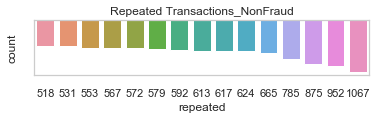

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set()
sns.set_style('whitegrid')
sns.set_color_codes()

#plt.rcParams["figure.figsize"] = (20,10)
plt.figure(figsize=(15,8))

# mpl.rc('font', family='nanumgothic')
# mpl.rc('axes', unicode_minus=False)

current_palette = sns.color_palette()
sns.palplot(sns.color_palette("Blues"))

sns.countplot(x="repeated", data=n)
plt.title("Repeated Transactions_NonFraud")
plt.show()

In [1]:
t

NameError: name 't' is not defined